# Case Study: testing




In [9]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
from matplotlib.lines import Line2D  # for legend handle
#import seaborn as sns
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from datetime import datetime

# imports from files
import functions
import read_cdp
import read_cip_txt
#import read_lwc
import read_nav
import read_cip_nc
import plots
import numb_conc
import read_seaice
#import in_cloud_detect
#from data_intake import read_sic
#from plots import plots.letter_annotation
from plots import plot_map

# surpress UserWarning connected to timezoneless np.datetime
warnings.filterwarnings("ignore", message="no explicit representation of timezones available for np.datetime64")
# surpress UserWrning connected to boolean series indexing (creating dataframe with null values)
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index.")

In [10]:
# --- Global formatting/settings/variables



# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# colors for flights (to use all the same colors!
c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:green',
              'IS22-03':'tab:red',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:blue',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:gray',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:cyan',
              'IS22-10':'tab:pink',
              'IS22-11':'tab:orange'}

# Threshold for in-cloud values
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

In [11]:
# --- Data import
# Based on scripts in files read_*.py

# Navigational data (nav_df: data variables, nav_stats_dict: statistics for each flight)
nav_df, nav_stats_dict, extra_info= read_nav.read_nav() # extra infor includes limits for the plots and extra landing and takeoff times
# get limits for plotting
campaign_coord_limits = {
    'lat_max': nav_df['Latitude (degree)'].max() + 1,
    'lat_min': nav_df['Latitude (degree)'].min() - 1,
    'lon_max': nav_df['Longitude (degree)'].max() + 1,
    'lon_min': nav_df['Longitude (degree)'].min() - 1
}

# CDP data (cdp_bulk_df: Bulk variables per flight, cdp_bins_df: Bin details (max, min size)
#           cdp_var_df: Variable information (names, units), cdp_meta_df: Metadata/instrument settings)
cdp_bulk_df, cdp_bins_df, cdp_var_df, cdp_meta_df = read_cdp.read_cdp(nav_df)

# CIP data 
# nc file(bulk information) (cip_bulk_calc_df: Bulk variables per flight, cip_conc_df: Concentration per bin, 
#                            cip_varnc_df: Variable, longname and unit)
cip_bulk_calc_df, cip_conc_df, cip_varnc_df = read_cip_nc.read_cip_nc() 
cip_pb_df, cip_bins_df, cip_var_df, cip_proc_df = read_cip_txt.read_cip_txt()



----Reading CDP files:
Reading: ../2022-islas/as220014/microphy/pads/20220403071511/02CDP 20220403071511.csv
Reading: ../2022-islas/as220009/microphy/pads/20220326080106/02CDP 20220326080106.csv
Reading: ../2022-islas/as220010/microphy/pads/02CDP 20220326133751.csv
Reading: ../2022-islas/as220007/microphy/pads/20220324080247/02CDP 20220322105458.csv
Reading: ../2022-islas/as220015/microphy/pads/20220403123534/02CDP 20220403123534.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324080247/02CDP 20220324080247.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324113123/02CDP 20220324113123.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324130909/02CDP 20220324130909.csv
Reading: ../2022-islas/as220013/microphy/pads/20220331093304/02CDP 20220331093304.csv
Reading: ../2022-islas/as220011/microphy/pads/02CDP 20220329081432.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330135853/02CDP 20220330135853.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330134834/

In [12]:
# -- Prepare dataframe for calculations
# Join the relevant columns from the nav, the cip, and the cdp data
# CIP IWC, LWC etc have been calculated for particles >100 mum
cip_df = cip_bulk_calc_df[['time', 'NT (#/m3)','IWC (gram/m3)','LWC (gram/m3)', 'MVD (um)']].sort_values(by='time', axis=0)
cdp_df = cdp_bulk_df[['time', 'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)','MVD (um)','Number Conc (#/cm^3)', 'LWC (g/m^3)']].sort_values(by='time', axis=0)

# rename columns to identify instrument and standardize units
cip_df = cip_df.rename(columns={'NT (#/m3)':'cip NumConc (#/m^3)','IWC (gram/m3)':'cip IWC (g/m^3)','LWC (gram/m3)':'cip LWC (g/m^3)', 'MVD (um)':'cip MVD (um)'})
cdp_df = cdp_df.rename(columns={'Number Conc corr (#/cm^3)': 'cdp NumConc corr (#/cm^3)', 'LWC corr (g/m^3)':'cdp LWC corr (g/m^3)',
                                'MVD (um)': 'cdp MVD (um)','Number Conc (#/cm^3)': 'cdp NumConc (#/cm^3)', 'LWC (g/m^3)':'cdp LWC (g/m^3)'})

# select temperature and flightid from nav
nav_sel_df = nav_df[['Latitude (degree)', 'Longitude (degree)','Altitude (meter)','Temperature (Celsius)','TAS (m/s)','flightid', 'safireid']].sort_values(by='time', axis=0)

# join cip and cdp by time
meas_df = pd.merge_asof(cip_df, cdp_df, on = 'time', direction = 'nearest', suffixes=('_cip','_cdp'))
microphy_df = pd.merge_asof(meas_df, nav_sel_df, on = 'time', direction = 'nearest')

# add manually set selection categories
microphy_df = functions.add_man_relevance(microphy_df) # relevant clouds: lower mixed phase
microphy_df = functions.add_man_cloud(microphy_df)     # cloudid: individual flight patterns from single flights

# prepare dataframe for later calculation of position in cloud and surface conditions:
microphy_df['Cloud_pos']=np.nan # empty column to be filled with cloud positions
microphy_df['Cloud_rel_alt']=np.nan # empty column to be filled with cloud relative altitude (0 = base 1 = top)
microphy_df['surface_cond']='sea-ocean' # set default to sea-ocean

# rearrange columns more logically: - Positional - Identifier - Ambient - Microphysical - Calculated
microphy_df = microphy_df[['time','Latitude (degree)','Longitude (degree)','Altitude (meter)',
                          'flightid', 'safireid',
                          'Temperature (Celsius)','TAS (m/s)',
                           'cip NumConc (#/m^3)','cdp NumConc (#/cm^3)','cdp NumConc corr (#/cm^3)',
                           'cip IWC (g/m^3)','cip LWC (g/m^3)','cdp LWC (g/m^3)','cdp LWC corr (g/m^3)',
                           'cip MVD (um)','cdp MVD (um)',
                           'Relevance','cloudid','Cloud_pos', 'Cloud_rel_alt', 'surface_cond']]


In [13]:
# -- Update surface_cond with land mask

def update_land(row):
    # Function to use globe_land_mask to check each lat, lon pair if land.
    # Returns the original value of 'surface_cond' if not land and 'land' if land

    # import package
    from global_land_mask import globe
    
    if globe.is_land(row['Latitude (degree)'], row['Longitude (degree)']):
        return 'land'
    return row['surface_cond']

# Apply the function to each row
microphy_df['surface_cond'] = microphy_df.apply(update_land, axis=1)

In [14]:
# --- calculated parameters

# Total number concentration (adding CIP and CDP)
microphy_df['cip NumConc (#/cm^3)'] = microphy_df['cip NumConc (#/m^3)']*10**(-6) # adjust cip to equal units as cdp
# sum cip and cdp in #/cm3 to find total num conc
microphy_df['tot NumConc (#/cm3)'] = microphy_df['cip NumConc (#/cm^3)']+microphy_df['cdp NumConc corr (#/cm^3)']

# TWC - Total Water Content: estimate total water content from cdp LWC and CIP IWC 
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)'] + microphy_df['cip IWC (g/m^3)']

# Selection of in-cloud values (True or False based on threshold condition)
in_cl_th = 0.01 # in-cloud threshold based on Korolev 2003
microphy_df['incloud']= microphy_df['TWC (gram/m3)']>in_cl_th #direct boolean indexing (True if bigger, False if smaller)

# -- incloud height calculations
# calculating in-cloud altitude dictionary for all named clouds:
cloud_alt_dict = functions.cloud_alt_pos(microphy_df, 'cloudid') # get the cloud top and base heights (in a dict)

# Calculating in-cloud relative altitude based on max and min altitude of cloud
cloudids = microphy_df[microphy_df['cloudid']!='nan']['cloudid'].unique() # get unique cloudids
microphy_df['Cloud_rel_alt']=microphy_df.apply(functions.rel_alt, args=(cloudids, cloud_alt_dict), axis=1)

# set category "Top-Bulk-Base", categorize data based on where in cloud:
# Apply the function row-wise to create the new column
microphy_df['Cloud_pos'] = microphy_df.apply(functions.set_c_pos_cat, cloud_pos_dict = cloud_alt_dict, axis=1)

In [15]:
# -- Calculate SLF (supercooled liquid fraction)
# estimate total water content from cdp as liquid and all from CIP as ice (use LWC from cdp and IWC from CIP)
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)']+microphy_df['cip IWC (g/m^3)']

# masking all values of TWC lower than in cloud threshold
microphy_df['TWC (gram/m3)'] = microphy_df['TWC (gram/m3)'].mask(microphy_df['TWC (gram/m3)'] < lwc_th)

# also mask cloud parameters for same time step
microphy_df['cdp LWC corr (g/m^3)'] = microphy_df['cdp LWC corr (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['cip IWC (g/m^3)'] = microphy_df['cip IWC (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['tot NumConc (#/cm3)'] = microphy_df['tot NumConc (#/cm3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))

# calculate SLF by dividing LWC with TWC
microphy_df['SLF']= microphy_df['cdp LWC corr (g/m^3)']/microphy_df['TWC (gram/m3)']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"Outside of cloud")

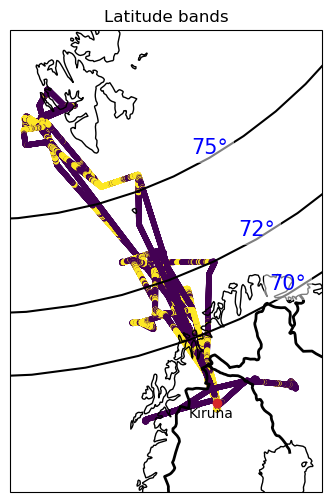

In [17]:
##### ---- Plot coordinates -----
#-- Map initialization based on flight info --

# Find the max and min lat and lon in the dataset
inc = 1
lat_max = microphy_df['Latitude (degree)'].max() + inc
lat_min = microphy_df['Latitude (degree)'].min() - inc
lon_max = microphy_df['Longitude (degree)'].max() + inc
lon_min = microphy_df['Longitude (degree)'].min() - inc

# coordinates of Kiruna
lat_kir = 67.8256
lon_kir = 20.3351

# --- Set up figure
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
data_projection = ccrs.PlateCarree()

# making a dictionary for setting the colors of the cloudid automatically


ax.scatter(microphy_df['Longitude (degree)'], microphy_df['Latitude (degree)'], marker='.',c =microphy_df['incloud'], transform = data_projection)

# Latitude bands (just do 3 cats)
ax.plot([0,5,10,15,20,25,30,35,40,45,50], [70,70,70,70,70,70,70,70,70,70,70], color='k', transform=ccrs.PlateCarree())
ax.plot([0,5,10,15,20,25,30,35,40,45,50], [72,72,72,72,72,72,72,72,72,72,72], color='k', transform=ccrs.PlateCarree())
#ax.plot([0,5,10,15,20,25,30,35,40,45,50], [73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5], color='k', transform=ccrs.PlateCarree())
ax.plot([0,5,10,15,20,25,30,35,40,45,50], [75,75,75,75,75,75,75,75,75,75,75], color='k', transform=ccrs.PlateCarree())

# Add text above the 70-degree latitude line
ax.text(30, 70, "70°",
        transform=ccrs.PlateCarree(),
        ha='center',
        va='bottom',
        fontsize=15,
        color='blue',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.text(30, 72, "72°",
        transform=ccrs.PlateCarree(),
        ha='center',
        va='bottom',
        fontsize=15,
        color='blue',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.text(30, 75, "75°",
        transform=ccrs.PlateCarree(),
        ha='center',
        va='bottom',
        fontsize=15,
        color='blue',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

#Plot Kiruna on map
ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
#Add text "Kiruna" at the plotted point
offset_lon = 0.7  # adjust the horizontal offset
offset_lat = -0.7  # adjust the vertical offset
ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_title('Latitude bands')


plt.savefig(f'Latitudebands/Latitude_bands.png')

In [18]:
# Preparations for plotting values as boxplots per latitude bands

# create categorical altitude variable based on altitude values
df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['Relevance']=='Lower clouds, relevant')]
df = df.copy() # make a copy to be able to freely make binning

# Define the bin edges for the altitude
altitude_bins = np.arange(0, df['Altitude (meter)'].max() + 300, 300) # based on max values in data

# Bin the altitude data
df['Altitude_bin'] = pd.cut(df['Altitude (meter)'], bins=altitude_bins)

# Group by the altitude bins and create a list of IWC values for each bin
binned_data = df.groupby('Altitude_bin', observed = True)['cip IWC (g/m^3)'].apply(list)

# Calculate the bin centers for plotting
bin_centers = [interval.mid for interval in binned_data.index.categories]

# list of altitude categories for plotting
alt_cats = binned_data.index.categories

# filter on latitude band
early_df = df[df['Latitude (degree)']>=75]
mid_df = df[(df['Latitude (degree)']<75) & (df['Latitude (degree)']>=72)]
late_df = df[df['Latitude (degree)']<72]

/tmp/ipykernel_13673/3187938729.py:70: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


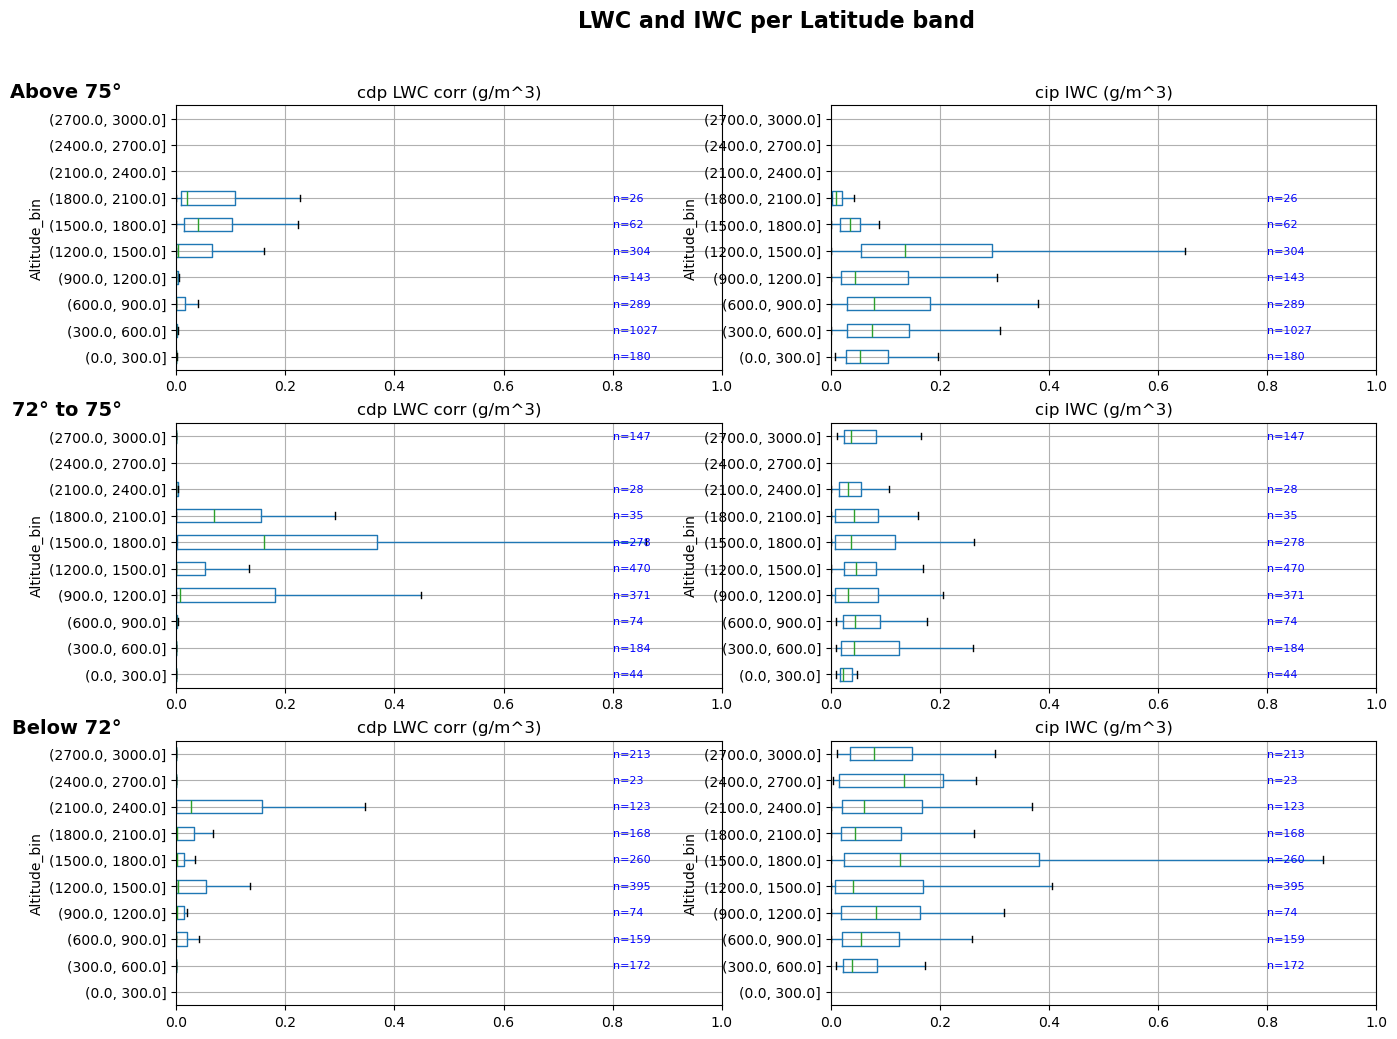

In [19]:
# LWC/IWC

# obs counts for plotting
early_oc_cdp = early_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
early_oc_cip = early_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()
mid_oc_cdp = mid_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
mid_oc_cip = mid_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()
late_oc_cdp = late_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
late_oc_cip = late_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()

fig, ax = plt.subplots(3,2,figsize=(15, 12))

# add the number of observations!!
early_df.boxplot(column='cdp LWC corr (g/m^3)', by= 'Altitude_bin', ax = ax[0,0], vert=False, showfliers=False)
early_df.boxplot(column='cip IWC (g/m^3)', by= 'Altitude_bin', ax = ax[0,1], vert=False, showfliers=False)


mid_df.boxplot(column='cdp LWC corr (g/m^3)', by= 'Altitude_bin', ax = ax[1,0], vert=False, showfliers=False)
mid_df.boxplot(column='cip IWC (g/m^3)', by= 'Altitude_bin', ax = ax[1,1], vert=False, showfliers=False)

late_df.boxplot(column='cdp LWC corr (g/m^3)', by= 'Altitude_bin', ax = ax[2,0], vert=False, showfliers=False)
late_df.boxplot(column='cip IWC (g/m^3)', by= 'Altitude_bin', ax = ax[2,1], vert=False, showfliers=False)

# Annotate the boxplots with the number of observations
# 75-cdp
for i, (cat, count) in enumerate(early_oc_cdp.items()):
    if count>0:
        ax[0,0].text(0.8, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-cip
for i, (cat, count) in enumerate(early_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[0,1].text(0.8, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 75-72-cdp
for i, (cat, count) in enumerate(mid_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,0].text(0.8, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-72-cip
for i, (cat, count) in enumerate(mid_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,1].text(0.8, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 72-cdp
for i, (cat, count) in enumerate(late_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,0].text(0.8, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 72-cip
for i, (cat, count) in enumerate(late_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,1].text(0.8, index_of_cat+1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
      

# Set titles for each row
row_titles = ['Above 75°', '72° to 75°', 'Below 72°']
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes,fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('LWC and IWC per Latitude band', fontsize=16, fontweight='bold')
plt.setp(ax, xlim=(0,1))

plt.savefig(f'Latitudebands/LWC_IWC_per_Latitude_bands.png')
#plt.show()

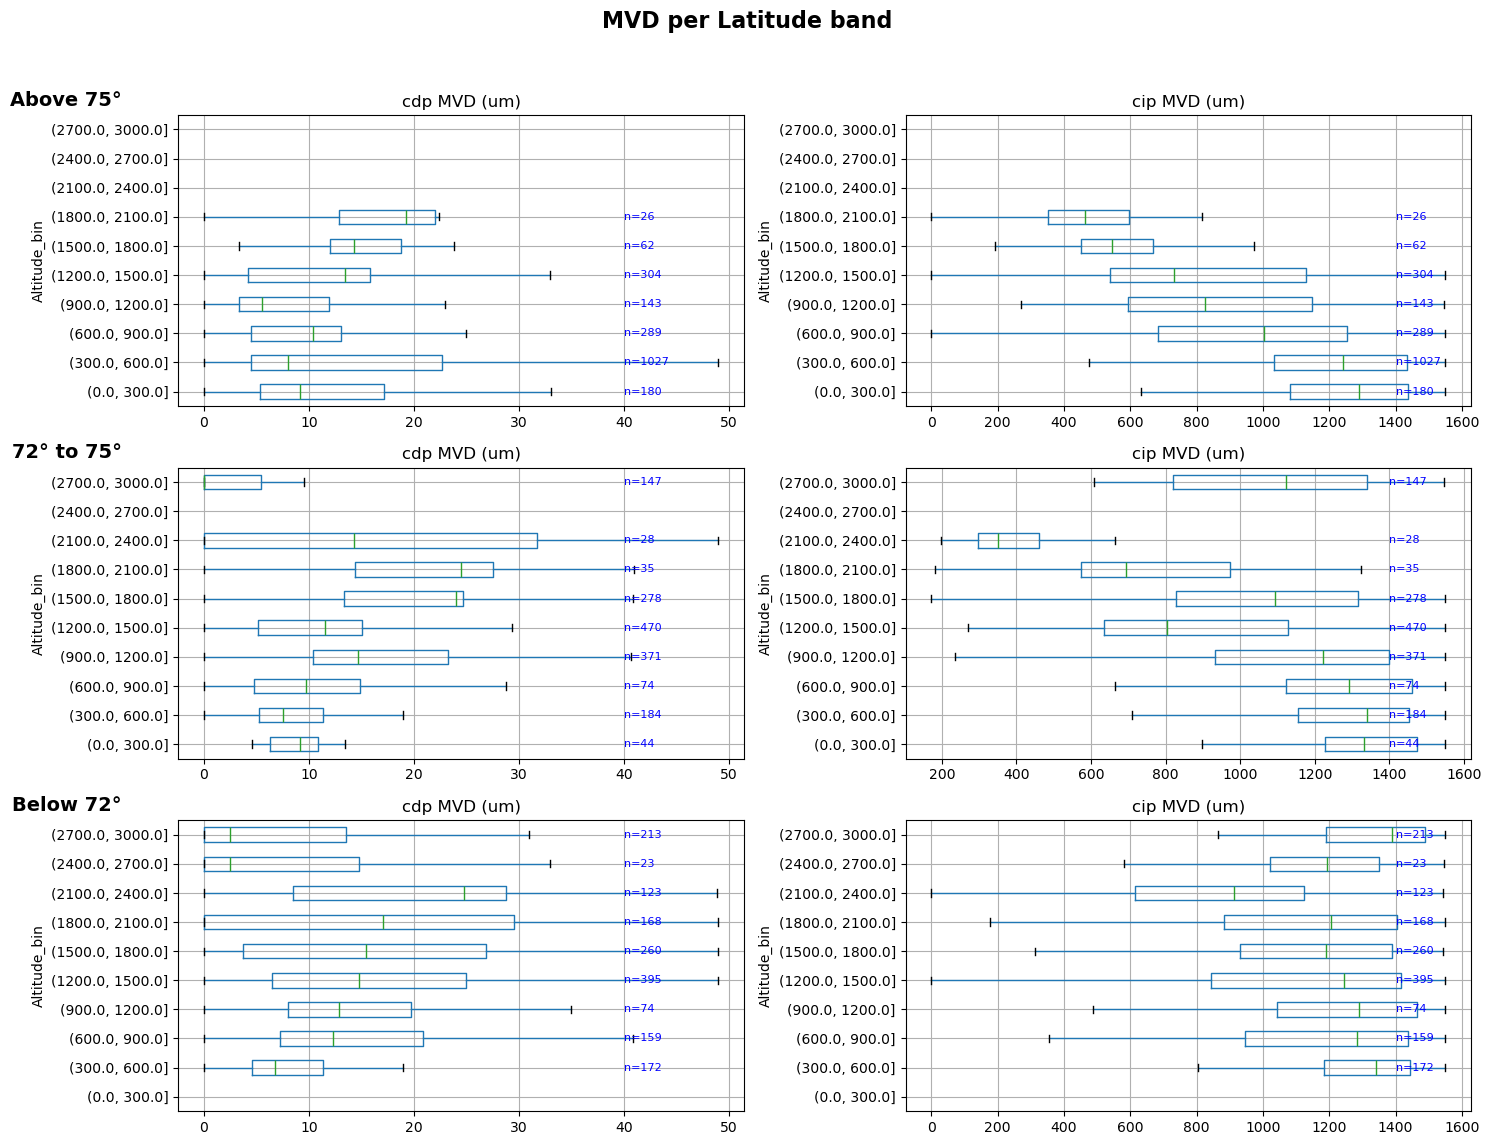

In [20]:
# MVD

# obs counts for plotting
early_oc_cdp = early_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
early_oc_cip = early_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()
mid_oc_cdp = mid_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
mid_oc_cip = mid_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()
late_oc_cdp = late_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
late_oc_cip = late_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()

fig, ax = plt.subplots(3,2,figsize=(15, 12))

# add the number of observations!!
early_df.boxplot(column='cdp MVD (um)', by= 'Altitude_bin', ax = ax[0,0], vert=False, showfliers=False)
early_df.boxplot(column='cip MVD (um)', by= 'Altitude_bin', ax = ax[0,1], vert=False, showfliers=False)


mid_df.boxplot(column='cdp MVD (um)', by= 'Altitude_bin', ax = ax[1,0], vert=False, showfliers=False)
mid_df.boxplot(column='cip MVD (um)', by= 'Altitude_bin', ax = ax[1,1], vert=False, showfliers=False)

late_df.boxplot(column='cdp MVD (um)', by= 'Altitude_bin', ax = ax[2,0], vert=False, showfliers=False)
late_df.boxplot(column='cip MVD (um)', by= 'Altitude_bin', ax = ax[2,1], vert=False, showfliers=False)

# Annotate the boxplots with the number of observations
# 75-cdp
for i, (cat, count) in enumerate(early_oc_cdp.items()):
    if count>0:
        ax[0,0].text(40, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-cip
for i, (cat, count) in enumerate(early_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[0,1].text(1400, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 75-72-cdp
for i, (cat, count) in enumerate(mid_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,0].text(40, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-72-cip
for i, (cat, count) in enumerate(mid_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,1].text(1400, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 72-cdp
for i, (cat, count) in enumerate(late_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,0].text(40, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 72-cip
for i, (cat, count) in enumerate(late_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,1].text(1400, index_of_cat+1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
      

# Set titles for each row
row_titles = ['Above 75°', '72° to 75°', 'Below 72°']
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes,fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('MVD per Latitude band', fontsize=16, fontweight='bold')
#plt.setp(ax, xlim=(0,1))

plt.savefig(f'Latitudebands/MVD_per_Latitude_bands.png')
#plt.show()

/tmp/ipykernel_13673/1313013155.py:40: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[i, 0].set_xlim(0, x_max)
/tmp/ipykernel_13673/1313013155.py:42: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[i, 1].set_xlim(0, x_max)


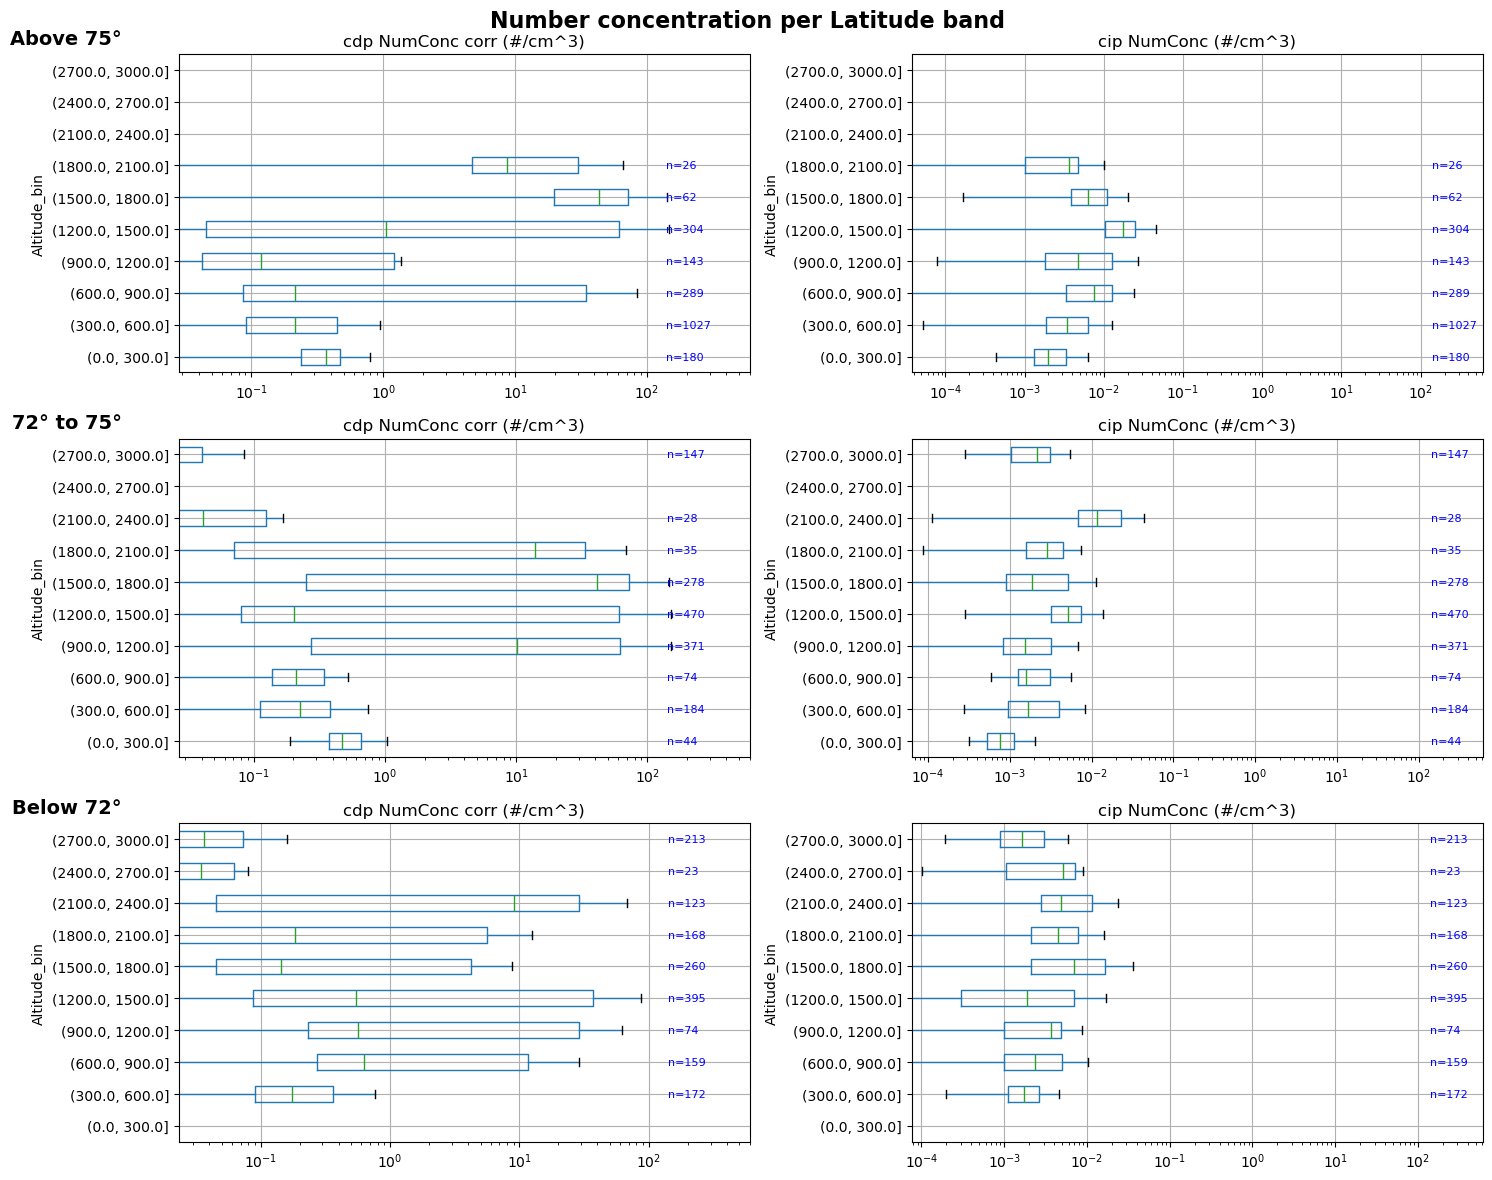

In [21]:
# Number concentration

# obs counts for plotting
early_oc_cdp = early_df.groupby('Altitude_bin', observed=True)['cdp NumConc corr (#/cm^3)'].count()
early_oc_cip = early_df.groupby('Altitude_bin', observed=True)['cip NumConc (#/cm^3)'].count()
mid_oc_cdp = mid_df.groupby('Altitude_bin', observed=True)['cdp NumConc corr (#/cm^3)'].count()
mid_oc_cip = mid_df.groupby('Altitude_bin', observed=True)['cip NumConc (#/cm^3)'].count()
late_oc_cdp = late_df.groupby('Altitude_bin', observed=True)['cdp NumConc corr (#/cm^3)'].count()
late_oc_cip = late_df.groupby('Altitude_bin', observed=True)['cip NumConc (#/cm^3)'].count()

fig, ax = plt.subplots(3,2,figsize=(15, 12))

# add the number of observations!!
early_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'Altitude_bin', ax = ax[0,0], vert=False, showfliers=False)
early_df.boxplot(column='cip NumConc (#/cm^3)', by= 'Altitude_bin', ax = ax[0,1], vert=False, showfliers=False)


mid_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'Altitude_bin', ax = ax[1,0], vert=False, showfliers=False)
mid_df.boxplot(column='cip NumConc (#/cm^3)', by= 'Altitude_bin', ax = ax[1,1], vert=False, showfliers=False)

late_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'Altitude_bin', ax = ax[2,0], vert=False, showfliers=False)
late_df.boxplot(column='cip NumConc (#/cm^3)', by= 'Altitude_bin', ax = ax[2,1], vert=False, showfliers=False)

# Find common x-axis limits
x_max = max(
    early_df['cdp NumConc corr (#/cm^3)'].max(),
    early_df['cip NumConc (#/cm^3)'].max(),
    mid_df['cdp NumConc corr (#/cm^3)'].max(),
    mid_df['cip NumConc (#/cm^3)'].max(),
    late_df['cdp NumConc corr (#/cm^3)'].max(),
    late_df['cip NumConc (#/cm^3)'].max()
)

# Set x-scale to logarithmic and use common x-limits for all subplots
for i in range(3):
    ax[i, 0].set_xscale('log')
    ax[i, 0].set_xlim(0, x_max)
    ax[i, 1].set_xscale('log')
    ax[i, 1].set_xlim(0, x_max)

# Annotate the boxplots with the number of observations
# 75-cdp
for i, (cat, count) in enumerate(early_oc_cdp.items()):
    if count>0:
        ax[0,0].text(140, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-cip
for i, (cat, count) in enumerate(early_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[0,1].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 75-72-cdp
for i, (cat, count) in enumerate(mid_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,0].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-72-cip
for i, (cat, count) in enumerate(mid_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,1].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 72-cdp
for i, (cat, count) in enumerate(late_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,0].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 72-cip
for i, (cat, count) in enumerate(late_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,1].text(140, index_of_cat+1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
      

# Set titles for each row
row_titles = ['Above 75°', '72° to 75°', 'Below 72°']
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes,fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
fig.tight_layout()
plt.suptitle('Number concentration per Latitude band', fontsize=16, fontweight='bold')

plt.savefig(f'Latitudebands/N_per_Latitude_bands.png')
#plt.show()